In [1]:
'''
!pip install konlpy
!pip install koeda
!pip install matplotlib
!pip install seaborn
'''

'\n!pip install konlpy\n!pip install koeda\n!pip install matplotlib\n!pip install seaborn\n'

In [2]:
# AEDA 사용방법
from koeda import AEDA

aeda = AEDA(
    morpheme_analyzer="Okt", punc_ratio=0.3, punctuations=[".", ",", "!", "?", ";", ":"]
)

text = "어머니가 집을 나가신다"

result = aeda(text)
print(result)

어머니가 . 집 ; 을 나가신다


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
train = pd.read_csv("./train.csv")

#### ver1,2 만들 때는 중복데이터 삭제하는 거 까먹음
### 중복 데이터 제거

In [5]:
train_is_duplicated = train.duplicated(subset=["sentence", "subject_entity", "object_entity"], keep=False)
df_duplicated = train.loc[train_is_duplicated, :]
df_duplicated.sort_values(by=["sentence"])
train_drop= train.drop_duplicates(subset=["sentence", "subject_entity", "object_entity"]).reset_index(drop=True)
train_drop

,id,sentence,subject_entity,object_entity,label,source
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia
...,...,...,...,...,...,...
32418,32465,한국당은 7일 오전 9시부터 오후 5시까지 진행된 원내대표 및 정책위의장 후보자 등...,"{'word': '유기준', 'start_idx': 93, 'end_idx': 95...","{'word': '부산 서구·동구', 'start_idx': 100, 'end_id...",per:employee_of,wikitree
32419,32466,"법포는 다시 최시형, 서병학, 손병희 직계인 북접과 다시 서장옥, 전봉준, 김개남을...","{'word': '최시형', 'start_idx': 7, 'end_idx': 9, ...","{'word': '손병희', 'start_idx': 17, 'end_idx': 19...",per:colleagues,wikipedia
32420,32467,완도군(군수 신우철)이 국토교통부에서 실시한 '2019 교통문화지수 실태조사'에서 ...,"{'word': '완도군', 'start_idx': 0, 'end_idx': 2, ...","{'word': '신우철', 'start_idx': 7, 'end_idx': 9, ...",org:top_members/employees,wikitree
32421,32468,"중앙일보, JTBC 회장을 지낸 이후 중앙홀딩스 회장, 재단법인 한반도평화만들기 이...","{'word': 'JTBC', 'start_idx': 6, 'end_idx': 9,...","{'word': '중앙홀딩스', 'start_idx': 21, 'end_idx': ...",no_relation,wikipedia


### 각 라벨 별로 문장의 개수 정보 저장

AEDA를 할 때 고려해야할 점:
1. 만약 entity 자리에 문장 기호가 들어간다면 정확도가 낮아지지 않을까?
2. per:place_of_death는 40개, no_relation은 9516개로 편차가 큰데 몇 개를 기준으로 증강해야 할까?

=> 데이터가 정말 부족한 하위 다섯개만 증강

In [6]:
from collections import defaultdict
label_num = defaultdict(int)
idx_1 = [] # "per:place_of_death" # "org:number_of_employees/members"
idx_2 = [] # 'org:dissolved' # 'per:schools_attended'
idx_3 = [] # 'per:religion' # 'org:political/religious_affiliation'
idx_4 = [] # 'per:siblings' # 'per:product'  #'org:founded_by' #'per:place_of_birth'
idx_5 = [] # 'per:other_family' #'per:place_of_residence'

for i in range(32423):
    label_num[train_drop['label'][i]] += 1
    if train_drop['label'][i] == "per:place_of_death" or train_drop['label'][i] == "org:number_of_employees/members":
        # 40개
        idx_1.append(i)
    elif train_drop['label'][i] == 'org:dissolved' or train_drop['label'][i] == 'per:schools_attended':
        # 60~80개
        idx_2.append(i)
    elif train_drop['label'][i] == 'per:religion' or train_drop['label'][i] == 'org:political/religious_affiliation':
        # 90개
        idx_3.append(i)
    elif train_drop['label'][i] == 'per:siblings' or train_drop['label'][i] == 'per:product' or train_drop['label'][i] == 'org:founded_by' or train_drop['label'][i] == 'per:place_of_birth':
        # 130 ~160개
        idx_4.append(i)
    elif train_drop['label'][i] == 'per:other_family' or train_drop['label'][i] == 'per:place_of_residence':
        # 190개
        idx_5.append(i)
    
print(label_num)

defaultdict(<class 'int'>, {'no_relation': 9516, 'org:member_of': 1864, 'org:top_members/employees': 4278, 'org:alternate_names': 1318, 'per:date_of_birth': 1130, 'org:place_of_headquarters': 1194, 'per:employee_of': 3567, 'per:origin': 1234, 'per:title': 2098, 'org:members': 420, 'per:schools_attended': 82, 'per:colleagues': 534, 'per:alternate_names': 997, 'per:spouse': 795, 'org:founded_by': 155, 'org:political/religious_affiliation': 98, 'per:children': 304, 'org:founded': 450, 'org:number_of_employees/members': 48, 'per:place_of_birth': 166, 'org:dissolved': 66, 'per:parents': 518, 'per:religion': 96, 'per:date_of_death': 417, 'per:place_of_residence': 193, 'per:other_family': 190, 'org:product': 380, 'per:siblings': 136, 'per:product': 139, 'per:place_of_death': 40})


In [7]:
train_1 = train_drop.iloc[idx_1]

In [8]:
for i in idx_1:
    aeda = AEDA(
            morpheme_analyzer="Okt",
            punc_ratio=0.3,
            punctuations=[".", ",", "!", "?", ";", ":"],
        )
    train_1['sentence'][i] = aeda(train_1['sentence'][i])
    #train_1['aeda_sentence'] = train_1['sentence'].apply(lambda x: aeda(x))

train_1

C:\Users\2jeon\AppData\Local\Temp\ipykernel_10176\3284471489.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_1['sentence'][i] = aeda(train_1['sentence'][i])


,id,sentence,subject_entity,object_entity,label,source
72,72,냉전 동안 독일 연방군은 NATO의 서유럽 방위 : 의 주력군이 되었으며 전군을 통...,"{'word': '독일 연방군', 'start_idx': 6, 'end_idx': ...","{'word': '49만 5,000명', 'start_idx': 46, 'end_i...",org:number_of_employees/members,wikipedia
205,205,"결국, 대한민국 정부 ? 의 반대에도 불구하고 주 : 한미군은 약 500 , 명의 ...","{'word': '군사고문단', 'start_idx': 37, 'end_idx': ...","{'word': '500명', 'start_idx': 31, 'end_idx': 3...",org:number_of_employees/members,wikipedia
954,954,한편 순천시는 : 아이 . 들 부터 노년까지 세대 . 맞춤 . 형 인구정책 추진으로...,"{'word': '순천시', 'start_idx': 3, 'end_idx': 5, ...","{'word': '281534명', 'start_idx': 77, 'end_idx'...",org:number_of_employees/members,wikitree
1026,1026,2010년에 전 소녀시대 멤버였던 제시카가 : 당시 멤버 9명 : 중 미니홈피나 블...,"{'word': '소녀시대', 'start_idx': 9, 'end_idx': 12...","{'word': '9명', 'start_idx': 30, 'end_idx': 31,...",org:number_of_employees/members,wikipedia
1044,1044,"2010년 ; 3월 29일 , , ? 최진영은 서울특별시 강남구 ! 논현동의 자택에...","{'word': '최진영', 'start_idx': 14, 'end_idx': 16...","{'word': '서울특별시 강남구', 'start_idx': 19, 'end_id...",per:place_of_death,wikipedia
...,...,...,...,...,...,...
30375,30413,2010년 5월 런던에서는 세계를 열광시켰던 스웨덴의 4인조 팝그룹 아바( ? AB...,"{'word': 'ABBA', 'start_idx': 41, 'end_idx': 4...","{'word': '4인', 'start_idx': 30, 'end_idx': 31,...",org:number_of_employees/members,wikipedia
30535,30573,"14 : 대 대선에서 낙선하고 정계 ; 를 ! 은퇴하였던 김대중이 정계 , 복귀와 ...","{'word': '민주당', 'start_idx': 55, 'end_idx': 57...","{'word': '95명', 'start_idx': 65, 'end_idx': 67...",org:number_of_employees/members,wikipedia
30922,30961,"순천시는 . 지난 14일, ; 13개 동 주민 ? 150 . 명과 함께 ; 주민들이...","{'word': '순천시', 'start_idx': 0, 'end_idx': 2, ...","{'word': '13개', 'start_idx': 13, 'end_idx': 15...",org:number_of_employees/members,wikitree
30948,30987,"1593년 6월 2차 진주성 전투에서 진주성이 ; 함락되자 의병장 , 인 김천일·고...","{'word': '고종후', 'start_idx': 40, 'end_idx': 42...","{'word': '진주성', 'start_idx': 12, 'end_idx': 14...",per:place_of_death,wikitree


In [9]:
train_2 = train_drop.iloc[idx_2]

for i in idx_2:
    aeda = AEDA(
            morpheme_analyzer="Okt",
            punc_ratio=0.3,
            punctuations=[".", ",", "!", "?", ";", ":"],
        )
    train_2['sentence'][i] = aeda(train_2['sentence'][i])

train_2

C:\Users\2jeon\AppData\Local\Temp\ipykernel_10176\2755391135.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_2['sentence'][i] = aeda(train_2['sentence'][i])


,id,sentence,subject_entity,object_entity,label,source
18,18,"문성민은 경기대학교에 입학하여 황동일, 신영석과 함께 경기대학교의 전성기를 이끌면서...","{'word': '문성민', 'start_idx': 0, 'end_idx': 2, ...","{'word': '경기대', 'start_idx': 5, 'end_idx': 7, ...",per:schools_attended,wikipedia
68,68,", 경성대학교 재학 시절 우완 투수 김기표와 입학 동기생이었는데 이 둘은 ! 입단 ...","{'word': '김기표', 'start_idx': 18, 'end_idx': 20...","{'word': '경성대', 'start_idx': 0, 'end_idx': 2, ...",per:schools_attended,wikipedia
102,102,"1959년 한국 전쟁 ! 으로 ? 폐교된 : 대성여자중학교 , 를 부활시키고 196...","{'word': '대성여자중학교', 'start_idx': 18, 'end_idx'...","{'word': '1959년', 'start_idx': 0, 'end_idx': 4...",org:dissolved,wikipedia
266,266,"2008년 3월 : 1일 , 제주교육대학교가 제주대학교에 통폐합 ! , 제주대학교 ...","{'word': '제주교육대학교', 'start_idx': 12, 'end_idx'...","{'word': '2008년 3월 1일', 'start_idx': 0, 'end_i...",org:dissolved,wikipedia
591,591,"2015년, 중앙희극학원에서 학업 생활을 하던 쟝쩐위는 프랑스의 영화 감독 '장-클...","{'word': '쟝쩐위', 'start_idx': 26, 'end_idx': 28...","{'word': '중앙희극학원', 'start_idx': 7, 'end_idx': ...",per:schools_attended,wikipedia
...,...,...,...,...,...,...
31045,31085,"현대 유니콘스의 마지막 해였던 2007년에는 마지막으로 다시 12 , 승을 거뒀다 ! .","{'word': '현대 유니콘스', 'start_idx': 0, 'end_idx':...","{'word': '2007년', 'start_idx': 17, 'end_idx': ...",org:dissolved,wikipedia
31221,31261,신 . 일고등학교 시절 광주제일고등학교의 최희섭과 함께 '고교 양대 거포'로 불렸고...,"{'word': '김광삼', 'start_idx': 60, 'end_idx': 62...","{'word': '신일고', 'start_idx': 45, 'end_idx': 47...",per:schools_attended,wikipedia
31658,31699,그러나 구민주계가 지방선거에서 좋지못한 실적 ? 을 거두고 구태정당 이라는 비난을 ...,"{'word': '중도개혁통합신당', 'start_idx': 59, 'end_idx...","{'word': '2007년 6월 27일', 'start_idx': 46, 'end...",org:dissolved,wikipedia
32127,32171,차터하우스 학교 ; 와 ! 옥스퍼드 대학교에서 공부 ? 한 존 웨슬리는 ? 옥스퍼드...,"{'word': '웨슬리', 'start_idx': 27, 'end_idx': 29...","{'word': '옥스퍼드 대학교', 'start_idx': 10, 'end_idx...",per:schools_attended,wikipedia


In [10]:
train_3 = train_drop.iloc[idx_3]

for i in idx_3:
    aeda = AEDA(
            morpheme_analyzer="Okt",
            punc_ratio=0.3,
            punctuations=[".", ",", "!", "?", ";", ":"],
        )
    train_3['sentence'][i] = aeda(train_3['sentence'][i])

train_3

C:\Users\2jeon\AppData\Local\Temp\ipykernel_10176\3084387853.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_3['sentence'][i] = aeda(train_3['sentence'][i])


,id,sentence,subject_entity,object_entity,label,source
50,50,1924년 11월 26일에는 ! 정부 형태 ; 를 군주제에서 인민 ; 공화제로 ? ...,"{'word': '몽골 인민 공화국', 'start_idx': 44, 'end_id...","{'word': '공화제', 'start_idx': 32, 'end_idx': 34...",org:political/religious_affiliation,wikipedia
150,150,개신교 신학자이자 유니온 신학교 교수로 일하던 라인 : 홀트 니부어가 신학 교수 자...,"{'word': '라인홀트 니부어', 'start_idx': 26, 'end_idx...","{'word': '개신교', 'start_idx': 0, 'end_idx': 2, ...",per:religion,wikipedia
244,244,또한 비문에는 사무드라굽타가 비슈누파 힌두교 신자라는 ? 내용 ; 이 언급되어 있는...,"{'word': '사무드라굽타', 'start_idx': 52, 'end_idx':...","{'word': '힌두교', 'start_idx': 21, 'end_idx': 23...",per:religion,wikipedia
279,279,러일 전쟁 때 일본군에 적극 협조하고 1905년 손병희가 동학의 전통을 이어 ; 반...,"{'word': '손병희', 'start_idx': 27, 'end_idx': 29...","{'word': '천도교', 'start_idx': 53, 'end_idx': 55...",per:religion,wikipedia
280,280,교황령의 ; 통치자 ! 인 교황 ? 은 가톨릭교회 ? 의 . 종교 지도자이기도 하였다.,"{'word': '교황령', 'start_idx': 0, 'end_idx': 2, ...","{'word': '가톨릭', 'start_idx': 14, 'end_idx': 16...",org:political/religious_affiliation,wikipedia
...,...,...,...,...,...,...
31302,31342,", 《원리강론》은 ; 통일교의 : 핵심 경전이며, ? 처음에는 《원리해설》이라는 이...","{'word': '문선명', 'start_idx': 42, 'end_idx': 44...","{'word': '통일교', 'start_idx': 8, 'end_idx': 10,...",per:religion,wikipedia
31304,31344,"퀘이커는 영국 : 정부에 의해 탄압 ? 받았으나, 퀘이커 신도 윌리엄 펜이 불하받은...","{'word': '윌리엄 펜', 'start_idx': 30, 'end_idx': ...","{'word': '퀘이커', 'start_idx': 23, 'end_idx': 25...",per:religion,wikipedia
31577,31618,"조 바이든은 1942년 ? 11월 20일, 펜실베이니아주 스크랜턴 의 아일랜드계 로...","{'word': '조 바이든', 'start_idx': 0, 'end_idx': 4...","{'word': '가톨릭', 'start_idx': 46, 'end_idx': 48...",per:religion,wikipedia
31703,31744,"한편, 호찌민이 이끄는 , 베트남 민주공화국(북베트남 . )의 공산주의 정치에 불안...","{'word': '베트남', 'start_idx': 13, 'end_idx': 15...","{'word': '공산주의', 'start_idx': 30, 'end_idx': 3...",org:political/religious_affiliation,wikipedia


In [11]:
train_4 = train_drop.iloc[idx_4]

for i in idx_4:
    aeda = AEDA(
            morpheme_analyzer="Okt",
            punc_ratio=0.3,
            punctuations=[".", ",", "!", "?", ";", ":"],
        )
    train_4['sentence'][i] = aeda(train_4['sentence'][i])

train_4

C:\Users\2jeon\AppData\Local\Temp\ipykernel_10176\3686007161.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_4['sentence'][i] = aeda(train_4['sentence'][i])


,id,sentence,subject_entity,object_entity,label,source
35,35,로버트 : 조지 (바비) 실(Robert George . (Bobby)(Bobby)...,"{'word': '흑표당', 'start_idx': 99, 'end_idx': 10...","{'word': '휴이 뉴튼', 'start_idx': 89, 'end_idx': ...",org:founded_by,wikipedia
91,91,"백한성(白漢成 : , 水原鶴人, ? 1899년 6월 15일 조선 충청도 공주 출생 ...","{'word': '백한성', 'start_idx': 0, 'end_idx': 2, ...","{'word': '조선 충청도 공주', 'start_idx': 28, 'end_id...",per:place_of_birth,wikipedia
234,234,"커널 샌더스(Colonel ; Sanders ! ) , 로 널리 알려져 있는 할랜드...","{'word': 'KFC', 'start_idx': 78, 'end_idx': 80...","{'word': '커널 샌더스', 'start_idx': 0, 'end_idx': ...",org:founded_by,wikipedia
278,278,"; 본래 하후(夏侯)씨로 : , . 하후돈(夏侯惇)과 ? 하후연의 숙부 , 였으나 ...","{'word': '하후돈', 'start_idx': 13, 'end_idx': 15...","{'word': '하후연', 'start_idx': 23, 'end_idx': 25...",per:siblings,wikipedia
459,459,", 1992년에는 에두아르드 . 리모노프와 알렉산드르 두긴을 중심으로 국민볼셰비키당...","{'word': '국민볼셰비키당', 'start_idx': 35, 'end_idx'...","{'word': '에두아르드 리모노프', 'start_idx': 8, 'end_id...",org:founded_by,wikipedia
...,...,...,...,...,...,...
32210,32254,"존 웨슬리가 구원에 이르는 믿음을 얻기 위해 고군분투하던 중, 동생 찰스 웨슬리도 ...","{'word': '존 웨슬리', 'start_idx': 0, 'end_idx': 4...","{'word': '동생 찰스 웨슬리', 'start_idx': 35, 'end_id...",per:siblings,wikipedia
32220,32264,"아다 헤게르베르그는 어린 , 시절에 : 언니 ! 인 안드리네 헤게르베르그와 함께 순...","{'word': '아다 헤게르베르그', 'start_idx': 0, 'end_idx...","{'word': '안드리네 헤게르베르그', 'start_idx': 22, 'end_...",per:siblings,wikipedia
32241,32287,"김대중은 11월에 평화민주당을 창 : 당하고, 본격 ! 적으로 대선에 뛰어들었다.","{'word': '김대중', 'start_idx': 0, 'end_idx': 2, ...","{'word': '평화민주당', 'start_idx': 10, 'end_idx': ...",per:product,wikipedia
32311,32358,"교수 시절이던 2007년 박근혜의 . 동생 박근령 . 과 ; 약혼했으며, 2008년...","{'word': '박근혜', 'start_idx': 14, 'end_idx': 16...","{'word': '박근령', 'start_idx': 22, 'end_idx': 24...",per:siblings,wikipedia


In [12]:
train_5 = train_drop.iloc[idx_5]

for i in idx_5:
    aeda = AEDA(
            morpheme_analyzer="Okt",
            punc_ratio=0.3,
            punctuations=[".", ",", "!", "?", ";", ":"],
        )
    train_5['sentence'][i] = aeda(train_5['sentence'][i])

train_5

C:\Users\2jeon\AppData\Local\Temp\ipykernel_10176\4019939126.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_5['sentence'][i] = aeda(train_5['sentence'][i])


,id,sentence,subject_entity,object_entity,label,source
167,167,이어 “6월 항쟁의 미완성을 통해 민주주의 ? 후퇴를 겪었다 : . ! 국민들이 촛...,"{'word': '문재인', 'start_idx': 50, 'end_idx': 52...","{'word': '대한민국', 'start_idx': 83, 'end_idx': 8...",per:place_of_residence,wikitree
199,199,그러나 빅토리아가 . 태어난 지 ? 1년 만에 에드워드는 사망했고 그녀는 말도 통하...,"{'word': '윌리엄 4세', 'start_idx': 70, 'end_idx':...","{'word': '빅토리아', 'start_idx': 4, 'end_idx': 7,...",per:other_family,wikipedia
230,230,"다만 역법 ; 의 시작을 이슬람력과 동일하게 , 무함마드 및 그의 추종자들이 메카에...","{'word': '무함마드', 'start_idx': 22, 'end_idx': 2...","{'word': '메디나', 'start_idx': 43, 'end_idx': 45...",per:place_of_residence,wikipedia
233,233,", 유한굉( , 劉漢宏, , Liu Hanhong, ~ 887년)은 , 중국 당나라...","{'word': '유한굉', 'start_idx': 0, 'end_idx': 2, ...","{'word': '중국 당나라', 'start_idx': 31, 'end_idx':...",per:place_of_residence,wikipedia
315,315,"전쟁은 ? 일본이 ! 개항하면서 에도 막부 , (도쿠가와 막부)의 이이 나오스케( ...","{'word': '이이 나오스케', 'start_idx': 30, 'end_idx'...","{'word': '히코네 번', 'start_idx': 38, 'end_idx': ...",per:place_of_residence,wikipedia
...,...,...,...,...,...,...
32273,32320,"칭기즈 칸의 씨족인 보르지긴은 ! 황금씨족 : (알탄 우룩)이라 불리며 , , 영지...","{'word': '칭기즈 칸', 'start_idx': 0, 'end_idx': 4...","{'word': '보르지긴', 'start_idx': 11, 'end_idx': 1...",per:other_family,wikipedia
32312,32359,"스코 천황 . 은 1398년 세상 . 을 떠났고 30년 후인 1428년 : , 그 ...","{'word': '쇼코 천황', 'start_idx': 50, 'end_idx': ...","{'word': '고하나조노 천황', 'start_idx': 62, 'end_idx...",per:other_family,wikipedia
32373,32420,"그러나 김양상의 친형제로 보기는 어렵고 사촌형제라고 ? 보기 ; 도 어려운데, 이는...","{'word': '원성왕', 'start_idx': 63, 'end_idx': 65...","{'word': '선덕왕', 'start_idx': 72, 'end_idx': 74...",per:other_family,wikipedia
32386,32433,"2008년 11월 5일, 드미트리 메드베데프 러시아 대통령은 : 모스크바 크렘린궁에...","{'word': '드미트리 메드베데프', 'start_idx': 14, 'end_i...","{'word': '러시아', 'start_idx': 25, 'end_idx': 27...",per:place_of_residence,wikipedia


In [13]:
tmp = pd.concat([train_1, train_2,train_3,train_4,train_5])
tmp
# 32423 + 332 = 32755

,id,sentence,subject_entity,object_entity,label,source
72,72,냉전 동안 독일 연방군은 NATO의 서유럽 방위 : 의 주력군이 되었으며 전군을 통...,"{'word': '독일 연방군', 'start_idx': 6, 'end_idx': ...","{'word': '49만 5,000명', 'start_idx': 46, 'end_i...",org:number_of_employees/members,wikipedia
205,205,"결국, 대한민국 정부 ? 의 반대에도 불구하고 주 : 한미군은 약 500 , 명의 ...","{'word': '군사고문단', 'start_idx': 37, 'end_idx': ...","{'word': '500명', 'start_idx': 31, 'end_idx': 3...",org:number_of_employees/members,wikipedia
954,954,한편 순천시는 : 아이 . 들 부터 노년까지 세대 . 맞춤 . 형 인구정책 추진으로...,"{'word': '순천시', 'start_idx': 3, 'end_idx': 5, ...","{'word': '281534명', 'start_idx': 77, 'end_idx'...",org:number_of_employees/members,wikitree
1026,1026,2010년에 전 소녀시대 멤버였던 제시카가 : 당시 멤버 9명 : 중 미니홈피나 블...,"{'word': '소녀시대', 'start_idx': 9, 'end_idx': 12...","{'word': '9명', 'start_idx': 30, 'end_idx': 31,...",org:number_of_employees/members,wikipedia
1044,1044,"2010년 ; 3월 29일 , , ? 최진영은 서울특별시 강남구 ! 논현동의 자택에...","{'word': '최진영', 'start_idx': 14, 'end_idx': 16...","{'word': '서울특별시 강남구', 'start_idx': 19, 'end_id...",per:place_of_death,wikipedia
...,...,...,...,...,...,...
32273,32320,"칭기즈 칸의 씨족인 보르지긴은 ! 황금씨족 : (알탄 우룩)이라 불리며 , , 영지...","{'word': '칭기즈 칸', 'start_idx': 0, 'end_idx': 4...","{'word': '보르지긴', 'start_idx': 11, 'end_idx': 1...",per:other_family,wikipedia
32312,32359,"스코 천황 . 은 1398년 세상 . 을 떠났고 30년 후인 1428년 : , 그 ...","{'word': '쇼코 천황', 'start_idx': 50, 'end_idx': ...","{'word': '고하나조노 천황', 'start_idx': 62, 'end_idx...",per:other_family,wikipedia
32373,32420,"그러나 김양상의 친형제로 보기는 어렵고 사촌형제라고 ? 보기 ; 도 어려운데, 이는...","{'word': '원성왕', 'start_idx': 63, 'end_idx': 65...","{'word': '선덕왕', 'start_idx': 72, 'end_idx': 74...",per:other_family,wikipedia
32386,32433,"2008년 11월 5일, 드미트리 메드베데프 러시아 대통령은 : 모스크바 크렘린궁에...","{'word': '드미트리 메드베데프', 'start_idx': 14, 'end_i...","{'word': '러시아', 'start_idx': 25, 'end_idx': 27...",per:place_of_residence,wikipedia


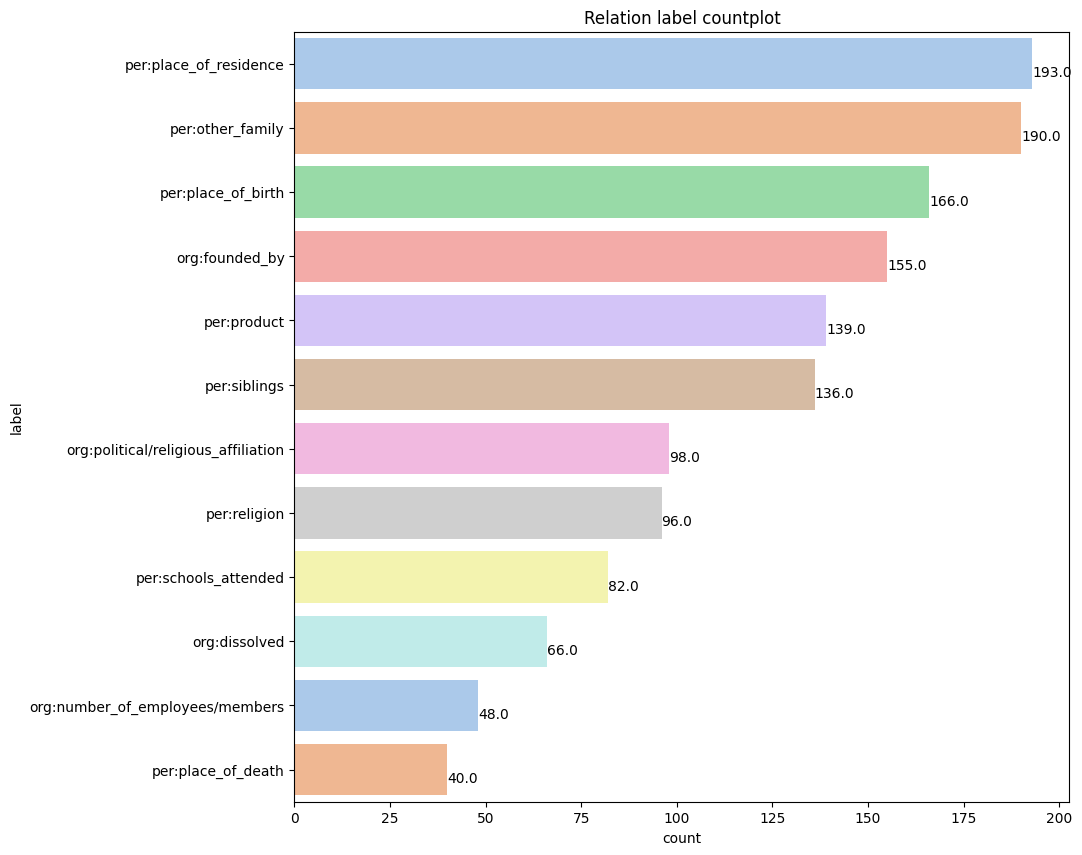

In [14]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax = sns.countplot(y='label', data= tmp, palette = sns.color_palette("pastel"), 
                    order = tmp['label'].value_counts().index, ax=ax)
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_x() + p.get_width(), p.get_y() + 0.6), fontsize=10)
plt.title("Relation label countplot")
plt.show()

### entity에 문자 들어간 거 필터링 
str.find(subject/object_entity) 리턴값이 -1일 경우 삭제

In [32]:
tmp = pd.concat([train_1, train_2,train_3,train_4,train_5])
tmp

,id,sentence,subject_entity,object_entity,label,source
72,72,냉전 동안 독일 연방군은 NATO의 서유럽 방위 : 의 주력군이 되었으며 전군을 통...,"{'word': '독일 연방군', 'start_idx': 6, 'end_idx': ...","{'word': '49만 5,000명', 'start_idx': 46, 'end_i...",org:number_of_employees/members,wikipedia
205,205,"결국, 대한민국 정부 ? 의 반대에도 불구하고 주 : 한미군은 약 500 , 명의 ...","{'word': '군사고문단', 'start_idx': 37, 'end_idx': ...","{'word': '500명', 'start_idx': 31, 'end_idx': 3...",org:number_of_employees/members,wikipedia
954,954,한편 순천시는 : 아이 . 들 부터 노년까지 세대 . 맞춤 . 형 인구정책 추진으로...,"{'word': '순천시', 'start_idx': 3, 'end_idx': 5, ...","{'word': '281534명', 'start_idx': 77, 'end_idx'...",org:number_of_employees/members,wikitree
1026,1026,2010년에 전 소녀시대 멤버였던 제시카가 : 당시 멤버 9명 : 중 미니홈피나 블...,"{'word': '소녀시대', 'start_idx': 9, 'end_idx': 12...","{'word': '9명', 'start_idx': 30, 'end_idx': 31,...",org:number_of_employees/members,wikipedia
1044,1044,"2010년 ; 3월 29일 , , ? 최진영은 서울특별시 강남구 ! 논현동의 자택에...","{'word': '최진영', 'start_idx': 14, 'end_idx': 16...","{'word': '서울특별시 강남구', 'start_idx': 19, 'end_id...",per:place_of_death,wikipedia
...,...,...,...,...,...,...
32273,32320,"칭기즈 칸의 씨족인 보르지긴은 ! 황금씨족 : (알탄 우룩)이라 불리며 , , 영지...","{'word': '칭기즈 칸', 'start_idx': 0, 'end_idx': 4...","{'word': '보르지긴', 'start_idx': 11, 'end_idx': 1...",per:other_family,wikipedia
32312,32359,"스코 천황 . 은 1398년 세상 . 을 떠났고 30년 후인 1428년 : , 그 ...","{'word': '쇼코 천황', 'start_idx': 50, 'end_idx': ...","{'word': '고하나조노 천황', 'start_idx': 62, 'end_idx...",per:other_family,wikipedia
32373,32420,"그러나 김양상의 친형제로 보기는 어렵고 사촌형제라고 ? 보기 ; 도 어려운데, 이는...","{'word': '원성왕', 'start_idx': 63, 'end_idx': 65...","{'word': '선덕왕', 'start_idx': 72, 'end_idx': 74...",per:other_family,wikipedia
32386,32433,"2008년 11월 5일, 드미트리 메드베데프 러시아 대통령은 : 모스크바 크렘린궁에...","{'word': '드미트리 메드베데프', 'start_idx': 14, 'end_i...","{'word': '러시아', 'start_idx': 25, 'end_idx': 27...",per:place_of_residence,wikipedia


In [34]:
i = 1

sentence = result['sentence'][i]
print(sentence)

sub_e = result['subject_entity'][i]
obj_e = result['object_entity'][i]
print(sub_e,' ', obj_e)
print(type(sub_e))

#{'word': '대성여자중학교', 'start_idx' 
start_s = result['subject_entity'][i].find('word')
end_s = result['subject_entity'][i].find('start_idx')
print(start_s, end_s)
print(sub_e[start_s+8: end_s-4])

start_o = result['object_entity'][i].find('word')
end_o = result['object_entity'][i].find('start_idx')
print(obj_e[start_o+8: end_o-4])

ch1 = sub_e[start_s+8: end_s-4]
ch2 = obj_e[start_o+8: end_o-4]
if ch1 in sentence and ch2 in sentence:
    print("True")
else:
    print("False")

호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으로 재탄생한다.
{'word': '민주평화당', 'start_idx': 19, 'end_idx': 23, 'type': 'ORG'}   {'word': '대안신당', 'start_idx': 14, 'end_idx': 17, 'type': 'ORG'}
<class 'str'>
2 19
민주평화당
대안신당
True


#### drop 문법 익히기

In [52]:
tmp_pd = tmp.copy()
tmp_pd

,id,sentence,subject_entity,object_entity,label,source
72,72,냉전 동안 독일 연방군은 NATO의 서유럽 방위 : 의 주력군이 되었으며 전군을 통...,"{'word': '독일 연방군', 'start_idx': 6, 'end_idx': ...","{'word': '49만 5,000명', 'start_idx': 46, 'end_i...",org:number_of_employees/members,wikipedia
205,205,"결국, 대한민국 정부 ? 의 반대에도 불구하고 주 : 한미군은 약 500 , 명의 ...","{'word': '군사고문단', 'start_idx': 37, 'end_idx': ...","{'word': '500명', 'start_idx': 31, 'end_idx': 3...",org:number_of_employees/members,wikipedia
954,954,한편 순천시는 : 아이 . 들 부터 노년까지 세대 . 맞춤 . 형 인구정책 추진으로...,"{'word': '순천시', 'start_idx': 3, 'end_idx': 5, ...","{'word': '281534명', 'start_idx': 77, 'end_idx'...",org:number_of_employees/members,wikitree
1026,1026,2010년에 전 소녀시대 멤버였던 제시카가 : 당시 멤버 9명 : 중 미니홈피나 블...,"{'word': '소녀시대', 'start_idx': 9, 'end_idx': 12...","{'word': '9명', 'start_idx': 30, 'end_idx': 31,...",org:number_of_employees/members,wikipedia
1044,1044,"2010년 ; 3월 29일 , , ? 최진영은 서울특별시 강남구 ! 논현동의 자택에...","{'word': '최진영', 'start_idx': 14, 'end_idx': 16...","{'word': '서울특별시 강남구', 'start_idx': 19, 'end_id...",per:place_of_death,wikipedia
...,...,...,...,...,...,...
32273,32320,"칭기즈 칸의 씨족인 보르지긴은 ! 황금씨족 : (알탄 우룩)이라 불리며 , , 영지...","{'word': '칭기즈 칸', 'start_idx': 0, 'end_idx': 4...","{'word': '보르지긴', 'start_idx': 11, 'end_idx': 1...",per:other_family,wikipedia
32312,32359,"스코 천황 . 은 1398년 세상 . 을 떠났고 30년 후인 1428년 : , 그 ...","{'word': '쇼코 천황', 'start_idx': 50, 'end_idx': ...","{'word': '고하나조노 천황', 'start_idx': 62, 'end_idx...",per:other_family,wikipedia
32373,32420,"그러나 김양상의 친형제로 보기는 어렵고 사촌형제라고 ? 보기 ; 도 어려운데, 이는...","{'word': '원성왕', 'start_idx': 63, 'end_idx': 65...","{'word': '선덕왕', 'start_idx': 72, 'end_idx': 74...",per:other_family,wikipedia
32386,32433,"2008년 11월 5일, 드미트리 메드베데프 러시아 대통령은 : 모스크바 크렘린궁에...","{'word': '드미트리 메드베데프', 'start_idx': 14, 'end_i...","{'word': '러시아', 'start_idx': 25, 'end_idx': 27...",per:place_of_residence,wikipedia


In [53]:
tmp_pd = tmp_pd.reset_index()
tmp_pd

,index,id,sentence,subject_entity,object_entity,label,source
0,72,72,냉전 동안 독일 연방군은 NATO의 서유럽 방위 : 의 주력군이 되었으며 전군을 통...,"{'word': '독일 연방군', 'start_idx': 6, 'end_idx': ...","{'word': '49만 5,000명', 'start_idx': 46, 'end_i...",org:number_of_employees/members,wikipedia
1,205,205,"결국, 대한민국 정부 ? 의 반대에도 불구하고 주 : 한미군은 약 500 , 명의 ...","{'word': '군사고문단', 'start_idx': 37, 'end_idx': ...","{'word': '500명', 'start_idx': 31, 'end_idx': 3...",org:number_of_employees/members,wikipedia
2,954,954,한편 순천시는 : 아이 . 들 부터 노년까지 세대 . 맞춤 . 형 인구정책 추진으로...,"{'word': '순천시', 'start_idx': 3, 'end_idx': 5, ...","{'word': '281534명', 'start_idx': 77, 'end_idx'...",org:number_of_employees/members,wikitree
3,1026,1026,2010년에 전 소녀시대 멤버였던 제시카가 : 당시 멤버 9명 : 중 미니홈피나 블...,"{'word': '소녀시대', 'start_idx': 9, 'end_idx': 12...","{'word': '9명', 'start_idx': 30, 'end_idx': 31,...",org:number_of_employees/members,wikipedia
4,1044,1044,"2010년 ; 3월 29일 , , ? 최진영은 서울특별시 강남구 ! 논현동의 자택에...","{'word': '최진영', 'start_idx': 14, 'end_idx': 16...","{'word': '서울특별시 강남구', 'start_idx': 19, 'end_id...",per:place_of_death,wikipedia
...,...,...,...,...,...,...,...
1404,32273,32320,"칭기즈 칸의 씨족인 보르지긴은 ! 황금씨족 : (알탄 우룩)이라 불리며 , , 영지...","{'word': '칭기즈 칸', 'start_idx': 0, 'end_idx': 4...","{'word': '보르지긴', 'start_idx': 11, 'end_idx': 1...",per:other_family,wikipedia
1405,32312,32359,"스코 천황 . 은 1398년 세상 . 을 떠났고 30년 후인 1428년 : , 그 ...","{'word': '쇼코 천황', 'start_idx': 50, 'end_idx': ...","{'word': '고하나조노 천황', 'start_idx': 62, 'end_idx...",per:other_family,wikipedia
1406,32373,32420,"그러나 김양상의 친형제로 보기는 어렵고 사촌형제라고 ? 보기 ; 도 어려운데, 이는...","{'word': '원성왕', 'start_idx': 63, 'end_idx': 65...","{'word': '선덕왕', 'start_idx': 72, 'end_idx': 74...",per:other_family,wikipedia
1407,32386,32433,"2008년 11월 5일, 드미트리 메드베데프 러시아 대통령은 : 모스크바 크렘린궁에...","{'word': '드미트리 메드베데프', 'start_idx': 14, 'end_i...","{'word': '러시아', 'start_idx': 25, 'end_idx': 27...",per:place_of_residence,wikipedia


In [54]:
i = 0
tmp_pd = tmp_pd.drop(labels=i,axis=0)
tmp_pd

,index,id,sentence,subject_entity,object_entity,label,source
1,205,205,"결국, 대한민국 정부 ? 의 반대에도 불구하고 주 : 한미군은 약 500 , 명의 ...","{'word': '군사고문단', 'start_idx': 37, 'end_idx': ...","{'word': '500명', 'start_idx': 31, 'end_idx': 3...",org:number_of_employees/members,wikipedia
2,954,954,한편 순천시는 : 아이 . 들 부터 노년까지 세대 . 맞춤 . 형 인구정책 추진으로...,"{'word': '순천시', 'start_idx': 3, 'end_idx': 5, ...","{'word': '281534명', 'start_idx': 77, 'end_idx'...",org:number_of_employees/members,wikitree
3,1026,1026,2010년에 전 소녀시대 멤버였던 제시카가 : 당시 멤버 9명 : 중 미니홈피나 블...,"{'word': '소녀시대', 'start_idx': 9, 'end_idx': 12...","{'word': '9명', 'start_idx': 30, 'end_idx': 31,...",org:number_of_employees/members,wikipedia
4,1044,1044,"2010년 ; 3월 29일 , , ? 최진영은 서울특별시 강남구 ! 논현동의 자택에...","{'word': '최진영', 'start_idx': 14, 'end_idx': 16...","{'word': '서울특별시 강남구', 'start_idx': 19, 'end_id...",per:place_of_death,wikipedia
5,1420,1420,"한편, 광주 서구는 ‘주민 . 주 ? 도의 좋은 마을만들기’사업을 통해 18개동에서...","{'word': '광주 서구', 'start_idx': 4, 'end_idx': 8...","{'word': '18개', 'start_idx': 34, 'end_idx': 36...",org:number_of_employees/members,wikitree
...,...,...,...,...,...,...,...
1404,32273,32320,"칭기즈 칸의 씨족인 보르지긴은 ! 황금씨족 : (알탄 우룩)이라 불리며 , , 영지...","{'word': '칭기즈 칸', 'start_idx': 0, 'end_idx': 4...","{'word': '보르지긴', 'start_idx': 11, 'end_idx': 1...",per:other_family,wikipedia
1405,32312,32359,"스코 천황 . 은 1398년 세상 . 을 떠났고 30년 후인 1428년 : , 그 ...","{'word': '쇼코 천황', 'start_idx': 50, 'end_idx': ...","{'word': '고하나조노 천황', 'start_idx': 62, 'end_idx...",per:other_family,wikipedia
1406,32373,32420,"그러나 김양상의 친형제로 보기는 어렵고 사촌형제라고 ? 보기 ; 도 어려운데, 이는...","{'word': '원성왕', 'start_idx': 63, 'end_idx': 65...","{'word': '선덕왕', 'start_idx': 72, 'end_idx': 74...",per:other_family,wikipedia
1407,32386,32433,"2008년 11월 5일, 드미트리 메드베데프 러시아 대통령은 : 모스크바 크렘린궁에...","{'word': '드미트리 메드베데프', 'start_idx': 14, 'end_i...","{'word': '러시아', 'start_idx': 25, 'end_idx': 27...",per:place_of_residence,wikipedia


### 찐 적용

In [55]:
tmp = tmp.reset_index()
tmp

,index,id,sentence,subject_entity,object_entity,label,source
0,72,72,냉전 동안 독일 연방군은 NATO의 서유럽 방위 : 의 주력군이 되었으며 전군을 통...,"{'word': '독일 연방군', 'start_idx': 6, 'end_idx': ...","{'word': '49만 5,000명', 'start_idx': 46, 'end_i...",org:number_of_employees/members,wikipedia
1,205,205,"결국, 대한민국 정부 ? 의 반대에도 불구하고 주 : 한미군은 약 500 , 명의 ...","{'word': '군사고문단', 'start_idx': 37, 'end_idx': ...","{'word': '500명', 'start_idx': 31, 'end_idx': 3...",org:number_of_employees/members,wikipedia
2,954,954,한편 순천시는 : 아이 . 들 부터 노년까지 세대 . 맞춤 . 형 인구정책 추진으로...,"{'word': '순천시', 'start_idx': 3, 'end_idx': 5, ...","{'word': '281534명', 'start_idx': 77, 'end_idx'...",org:number_of_employees/members,wikitree
3,1026,1026,2010년에 전 소녀시대 멤버였던 제시카가 : 당시 멤버 9명 : 중 미니홈피나 블...,"{'word': '소녀시대', 'start_idx': 9, 'end_idx': 12...","{'word': '9명', 'start_idx': 30, 'end_idx': 31,...",org:number_of_employees/members,wikipedia
4,1044,1044,"2010년 ; 3월 29일 , , ? 최진영은 서울특별시 강남구 ! 논현동의 자택에...","{'word': '최진영', 'start_idx': 14, 'end_idx': 16...","{'word': '서울특별시 강남구', 'start_idx': 19, 'end_id...",per:place_of_death,wikipedia
...,...,...,...,...,...,...,...
1404,32273,32320,"칭기즈 칸의 씨족인 보르지긴은 ! 황금씨족 : (알탄 우룩)이라 불리며 , , 영지...","{'word': '칭기즈 칸', 'start_idx': 0, 'end_idx': 4...","{'word': '보르지긴', 'start_idx': 11, 'end_idx': 1...",per:other_family,wikipedia
1405,32312,32359,"스코 천황 . 은 1398년 세상 . 을 떠났고 30년 후인 1428년 : , 그 ...","{'word': '쇼코 천황', 'start_idx': 50, 'end_idx': ...","{'word': '고하나조노 천황', 'start_idx': 62, 'end_idx...",per:other_family,wikipedia
1406,32373,32420,"그러나 김양상의 친형제로 보기는 어렵고 사촌형제라고 ? 보기 ; 도 어려운데, 이는...","{'word': '원성왕', 'start_idx': 63, 'end_idx': 65...","{'word': '선덕왕', 'start_idx': 72, 'end_idx': 74...",per:other_family,wikipedia
1407,32386,32433,"2008년 11월 5일, 드미트리 메드베데프 러시아 대통령은 : 모스크바 크렘린궁에...","{'word': '드미트리 메드베데프', 'start_idx': 14, 'end_i...","{'word': '러시아', 'start_idx': 25, 'end_idx': 27...",per:place_of_residence,wikipedia


In [58]:
idx = []
for i in range(1409):
    sentence = tmp['sentence'][i]
    sub_e = tmp['subject_entity'][i]
    obj_e = tmp['object_entity'][i]

    start_s = tmp['subject_entity'][i].find('word')
    end_s = tmp['subject_entity'][i].find('start_idx')
    ch1 = sub_e[start_s+8: end_s-4]

    start_o = tmp['object_entity'][i].find('word')
    end_o = tmp['object_entity'][i].find('start_idx')
    ch2 = obj_e[start_o+8: end_o-4]
    
    if not (ch1 in sentence and ch2 in sentence):
        idx.append(i)
        tmp = tmp.drop(labels=i, axis = 0)
print(idx)
tmp

[1, 7, 8, 19, 23, 26, 28, 33, 34, 41, 44, 48, 54, 63, 67, 68, 72, 73, 78, 84, 91, 96, 98, 103, 104, 105, 108, 112, 113, 114, 121, 125, 126, 130, 131, 135, 138, 139, 142, 144, 146, 148, 156, 160, 165, 168, 169, 170, 190, 199, 203, 205, 206, 207, 208, 214, 221, 223, 224, 227, 237, 241, 242, 243, 255, 268, 301, 304, 314, 328, 329, 333, 340, 344, 353, 373, 380, 381, 385, 389, 397, 408, 409, 429, 430, 434, 436, 437, 439, 440, 443, 447, 450, 459, 482, 483, 486, 489, 494, 503, 519, 520, 522, 530, 532, 535, 537, 538, 548, 551, 557, 558, 559, 562, 564, 572, 573, 577, 579, 580, 582, 584, 587, 588, 592, 593, 596, 602, 610, 611, 614, 617, 621, 622, 632, 634, 637, 641, 645, 646, 647, 649, 654, 658, 659, 660, 663, 666, 671, 675, 677, 680, 681, 682, 683, 689, 692, 693, 699, 701, 704, 706, 709, 713, 714, 718, 721, 723, 725, 727, 732, 742, 745, 749, 754, 759, 766, 768, 770, 772, 773, 788, 793, 794, 795, 796, 798, 800, 801, 813, 816, 820, 821, 823, 825, 831, 836, 837, 844, 845, 849, 850, 851, 863, 866, 

,index,id,sentence,subject_entity,object_entity,label,source
0,72,72,냉전 동안 독일 연방군은 NATO의 서유럽 방위 : 의 주력군이 되었으며 전군을 통...,"{'word': '독일 연방군', 'start_idx': 6, 'end_idx': ...","{'word': '49만 5,000명', 'start_idx': 46, 'end_i...",org:number_of_employees/members,wikipedia
2,954,954,한편 순천시는 : 아이 . 들 부터 노년까지 세대 . 맞춤 . 형 인구정책 추진으로...,"{'word': '순천시', 'start_idx': 3, 'end_idx': 5, ...","{'word': '281534명', 'start_idx': 77, 'end_idx'...",org:number_of_employees/members,wikitree
3,1026,1026,2010년에 전 소녀시대 멤버였던 제시카가 : 당시 멤버 9명 : 중 미니홈피나 블...,"{'word': '소녀시대', 'start_idx': 9, 'end_idx': 12...","{'word': '9명', 'start_idx': 30, 'end_idx': 31,...",org:number_of_employees/members,wikipedia
4,1044,1044,"2010년 ; 3월 29일 , , ? 최진영은 서울특별시 강남구 ! 논현동의 자택에...","{'word': '최진영', 'start_idx': 14, 'end_idx': 16...","{'word': '서울특별시 강남구', 'start_idx': 19, 'end_id...",per:place_of_death,wikipedia
5,1420,1420,"한편, 광주 서구는 ‘주민 . 주 ? 도의 좋은 마을만들기’사업을 통해 18개동에서...","{'word': '광주 서구', 'start_idx': 4, 'end_idx': 8...","{'word': '18개', 'start_idx': 34, 'end_idx': 36...",org:number_of_employees/members,wikitree
...,...,...,...,...,...,...,...
1401,31931,31975,". 유력자의 협력 하 . 에 필리핀 헌법을 만들고, 호세 라우렐 ? 을 : 대통령으...","{'word': '호세 라우렐', 'start_idx': 24, 'end_idx':...","{'word': '필리핀', 'start_idx': 11, 'end_idx': 13...",per:place_of_residence,wikipedia
1404,32273,32320,"칭기즈 칸의 씨족인 보르지긴은 ! 황금씨족 : (알탄 우룩)이라 불리며 , , 영지...","{'word': '칭기즈 칸', 'start_idx': 0, 'end_idx': 4...","{'word': '보르지긴', 'start_idx': 11, 'end_idx': 1...",per:other_family,wikipedia
1406,32373,32420,"그러나 김양상의 친형제로 보기는 어렵고 사촌형제라고 ? 보기 ; 도 어려운데, 이는...","{'word': '원성왕', 'start_idx': 63, 'end_idx': 65...","{'word': '선덕왕', 'start_idx': 72, 'end_idx': 74...",per:other_family,wikipedia
1407,32386,32433,"2008년 11월 5일, 드미트리 메드베데프 러시아 대통령은 : 모스크바 크렘린궁에...","{'word': '드미트리 메드베데프', 'start_idx': 14, 'end_i...","{'word': '러시아', 'start_idx': 25, 'end_idx': 27...",per:place_of_residence,wikipedia


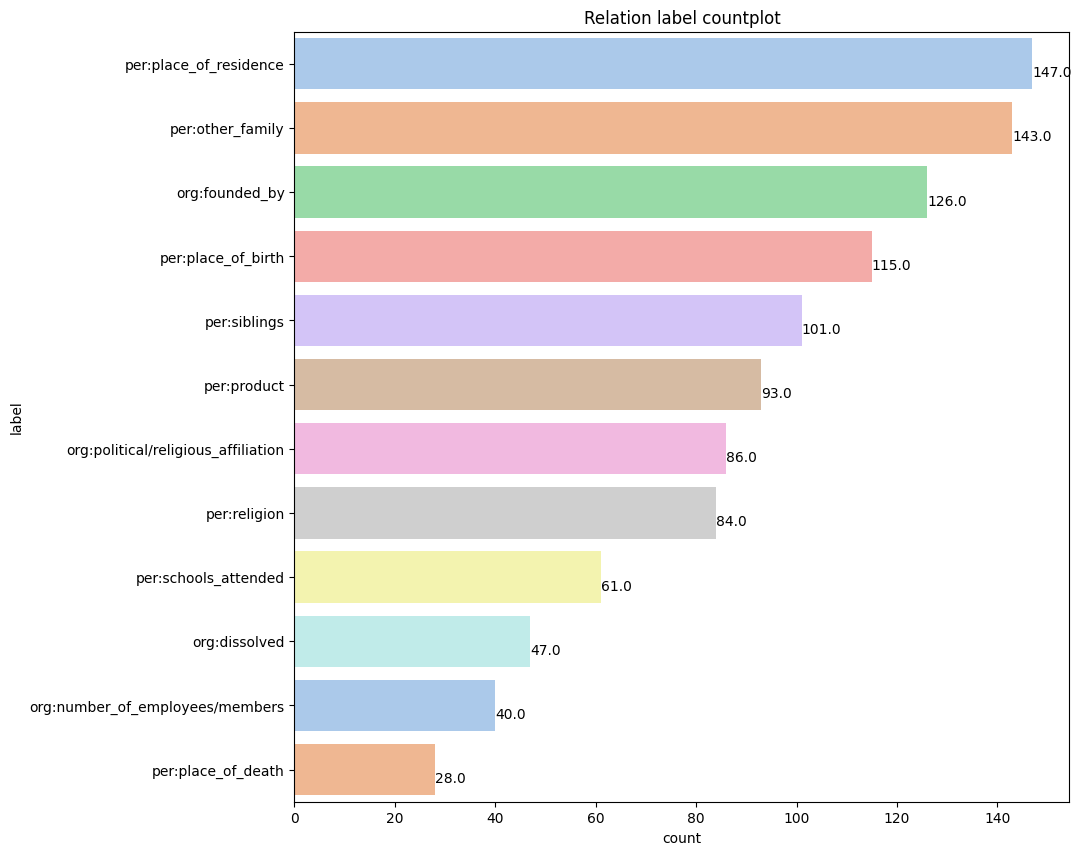

In [62]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax = sns.countplot(y='label', data= tmp, palette = sns.color_palette("pastel"), 
                    order = tmp['label'].value_counts().index, ax=ax)
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_x() + p.get_width(), p.get_y() + 0.6), fontsize=10)
plt.title("Relation label countplot")
plt.show()

In [63]:
tmp.to_csv('./tmp.csv', index=False)

### 증강 데이터 합체

In [59]:
result = pd.concat([train_drop, tmp])
result

,id,sentence,subject_entity,object_entity,label,source,index
0,0,〈Something〉는 조지 해리슨이 쓰고 비틀즈가 1969년 앨범 《Abbey R...,"{'word': '비틀즈', 'start_idx': 24, 'end_idx': 26...","{'word': '조지 해리슨', 'start_idx': 13, 'end_idx':...",no_relation,wikipedia,NaN
1,1,호남이 기반인 바른미래당·대안신당·민주평화당이 우여곡절 끝에 합당해 민생당(가칭)으...,"{'word': '민주평화당', 'start_idx': 19, 'end_idx': ...","{'word': '대안신당', 'start_idx': 14, 'end_idx': 1...",no_relation,wikitree,NaN
2,2,K리그2에서 성적 1위를 달리고 있는 광주FC는 지난 26일 한국프로축구연맹으로부터...,"{'word': '광주FC', 'start_idx': 21, 'end_idx': 2...","{'word': '한국프로축구연맹', 'start_idx': 34, 'end_idx...",org:member_of,wikitree,NaN
3,3,균일가 생활용품점 (주)아성다이소(대표 박정부)는 코로나19 바이러스로 어려움을 겪...,"{'word': '아성다이소', 'start_idx': 13, 'end_idx': ...","{'word': '박정부', 'start_idx': 22, 'end_idx': 24...",org:top_members/employees,wikitree,NaN
4,4,1967년 프로 야구 드래프트 1순위로 요미우리 자이언츠에게 입단하면서 등번호는 8...,"{'word': '요미우리 자이언츠', 'start_idx': 22, 'end_id...","{'word': '1967', 'start_idx': 0, 'end_idx': 3,...",no_relation,wikipedia,NaN
...,...,...,...,...,...,...,...
1401,31975,". 유력자의 협력 하 . 에 필리핀 헌법을 만들고, 호세 라우렐 ? 을 : 대통령으...","{'word': '호세 라우렐', 'start_idx': 24, 'end_idx':...","{'word': '필리핀', 'start_idx': 11, 'end_idx': 13...",per:place_of_residence,wikipedia,31931.0
1404,32320,"칭기즈 칸의 씨족인 보르지긴은 ! 황금씨족 : (알탄 우룩)이라 불리며 , , 영지...","{'word': '칭기즈 칸', 'start_idx': 0, 'end_idx': 4...","{'word': '보르지긴', 'start_idx': 11, 'end_idx': 1...",per:other_family,wikipedia,32273.0
1406,32420,"그러나 김양상의 친형제로 보기는 어렵고 사촌형제라고 ? 보기 ; 도 어려운데, 이는...","{'word': '원성왕', 'start_idx': 63, 'end_idx': 65...","{'word': '선덕왕', 'start_idx': 72, 'end_idx': 74...",per:other_family,wikipedia,32373.0
1407,32433,"2008년 11월 5일, 드미트리 메드베데프 러시아 대통령은 : 모스크바 크렘린궁에...","{'word': '드미트리 메드베데프', 'start_idx': 14, 'end_i...","{'word': '러시아', 'start_idx': 25, 'end_idx': 27...",per:place_of_residence,wikipedia,32386.0


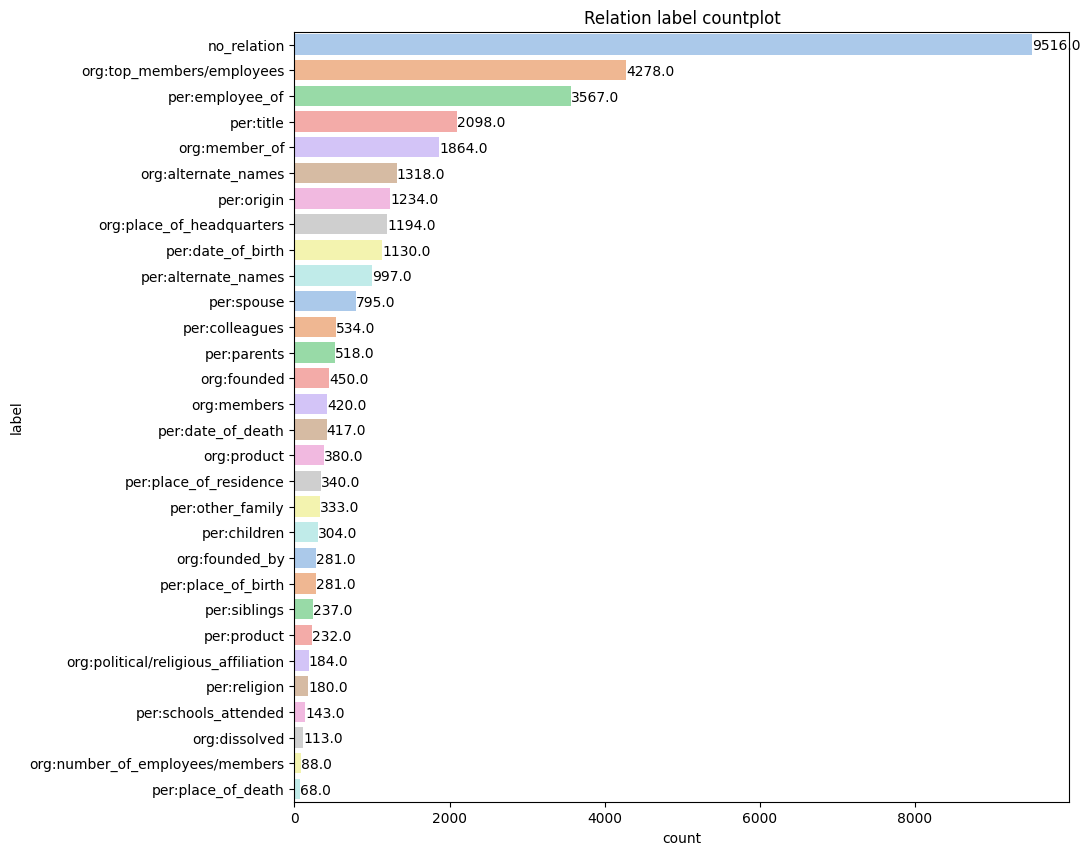

In [60]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax = sns.countplot(y='label', data=result, palette = sns.color_palette("pastel"), 
                    order = result['label'].value_counts().index, ax=ax)
for p in ax.patches:
    ax.annotate(f'{p.get_width()}', (p.get_x() + p.get_width(), p.get_y() + 0.6), fontsize=10)
plt.title("Relation label countplot")
plt.show()

In [61]:
result.to_csv('./train_aug_ver5.csv', index=False)